[*********************100%***********************]  1 of 1 completed


Выходные данные были обрезаны до нескольких последних строк (5000).
10:	learn: 308.0715723	total: 7.44ms	remaining: 331ms
11:	learn: 297.9584331	total: 8.19ms	remaining: 333ms
12:	learn: 286.7575734	total: 8.86ms	remaining: 332ms
13:	learn: 277.7578930	total: 9.49ms	remaining: 329ms
14:	learn: 269.7880396	total: 10.1ms	remaining: 327ms
15:	learn: 261.4851267	total: 10.7ms	remaining: 325ms
16:	learn: 254.2185826	total: 11ms	remaining: 313ms
17:	learn: 246.8459840	total: 11.6ms	remaining: 311ms
18:	learn: 239.0809200	total: 12.2ms	remaining: 310ms
19:	learn: 233.0196459	total: 13.1ms	remaining: 315ms
20:	learn: 227.9325417	total: 13.7ms	remaining: 313ms
21:	learn: 221.5947529	total: 14.3ms	remaining: 311ms
22:	learn: 216.9929491	total: 15ms	remaining: 310ms
23:	learn: 211.6854549	total: 15.6ms	remaining: 310ms
24:	learn: 207.0952807	total: 16.2ms	remaining: 308ms
25:	learn: 203.0497219	total: 16.8ms	remaining: 307ms
26:	learn: 199.4496248	total: 18.3ms	remaining: 320ms
27:	learn: 195.738

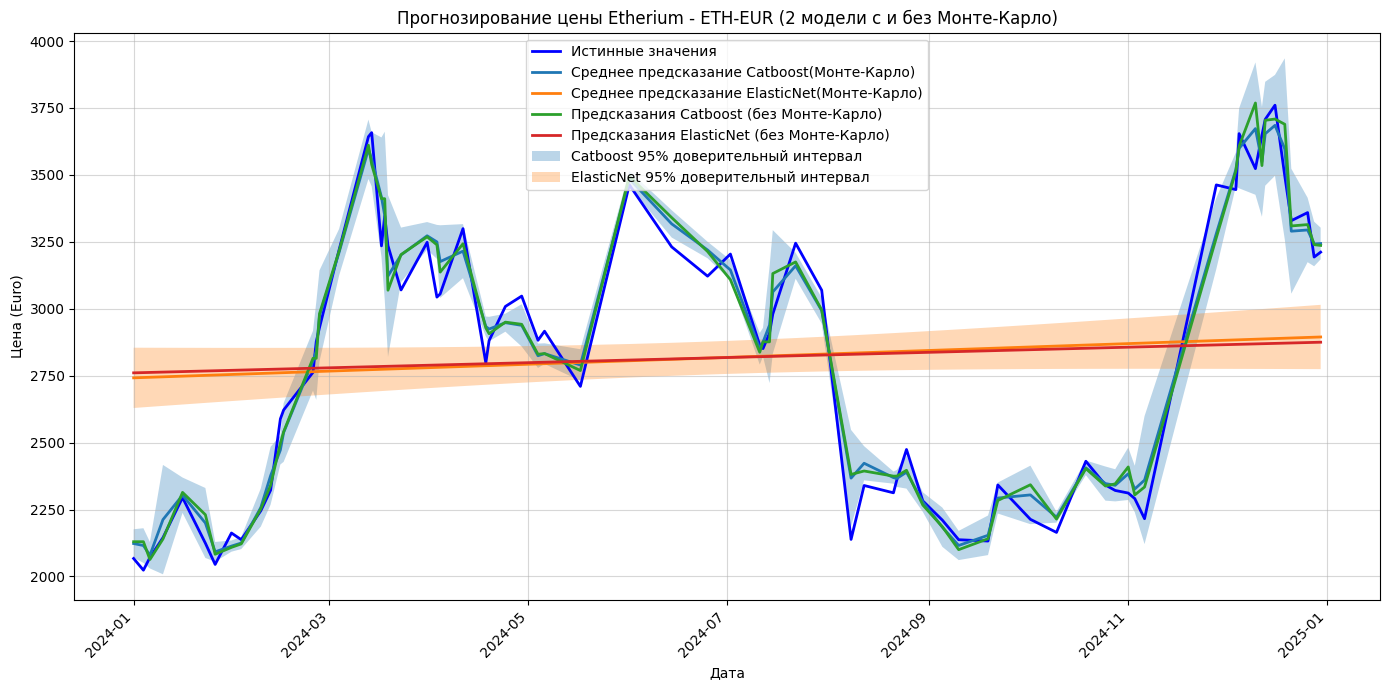

Метрики без Монте-Карло:
CatBoost - MSE: 8077.3679, R²: 0.9704
ElasticNet - MSE: 264440.7665, R²: 0.0314

Метрики с Монте-Карло:
CatBoost - MSE: 6838.5982, R²: 0.9750
ElasticNet - MSE: 262115.1553, R²: 0.0399


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import ElasticNet
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional

@dataclass
class ModelMetrics:
    """Хранение метрик модели"""
    mse: float
    r2: float

class DataLoader:
    """Загрузка и подготовка данных"""
    def __init__(self, ticker: str, start_date: str, end_date: str):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None

    def load_data(self) -> pd.DataFrame:
        """Загрузка данных с Yahoo Finance"""
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        self.data.reset_index(inplace=True)
        return self._prepare_data()

    def _prepare_data(self) -> pd.DataFrame:
        """Подготовка данных"""
        self.data["Date"] = pd.to_datetime(self.data["Date"])
        self.data["Time_Index"] = np.arange(len(self.data))
        return self.data

class ModelTrainer:
    """Базовый класс для обучения моделей"""
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = None
        self.metrics = {}

    def train(self):
        """Обучение модели"""
        raise NotImplementedError

    def predict(self):
        """Предсказание модели"""
        raise NotImplementedError

    def evaluate(self) -> ModelMetrics:
        """Оценка качества модели"""
        predictions = self.predict()
        mse = mean_squared_error(self.y_test, predictions)
        r2 = r2_score(self.y_test, predictions)
        return ModelMetrics(mse, r2)

class CatBoostTrainer(ModelTrainer):
    """Тренировка CatBoost модели"""
    def __init__(self, X_train, X_test, y_train, y_test, params: Dict):
        super().__init__(X_train, X_test, y_train, y_test)
        self.params = params

    def train(self):
        """Обучение CatBoost модели"""
        self.model = CatBoostRegressor(**self.params)
        self.model.fit(self.X_train, self.y_train.ravel(), verbose=0)

    def predict(self):
        """Предсказание модели"""
        return self.model.predict(self.X_test)

class ElasticNetTrainer(ModelTrainer):
    """Тренировка ElasticNet модели"""
    def __init__(self, X_train, X_test, y_train, y_test, params: Dict):
        super().__init__(X_train, X_test, y_train, y_test)
        self.params = params
        self.scaler = StandardScaler()

    def train(self):
        """Обучение ElasticNet модели с нормализацией данных"""
        # Нормализация данных
        X_train_scaled = self.scaler.fit_transform(self.X_train)
        X_test_scaled = self.scaler.transform(self.X_test)

        self.X_train = X_train_scaled
        self.X_test = X_test_scaled

        # Обучение модели
        self.model = ElasticNet(**self.params)
        self.model.fit(self.X_train, self.y_train.ravel())

    def predict(self):
        """Предсказание модели"""
        return self.model.predict(self.X_test)

class MonteCarloSimulator:
    """Класс для выполнения Монте-Карло симуляций"""
    def __init__(self, model_class, X_train, X_test, y_train, n_simulations: int = 35):
        self.model_class = model_class
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.n_simulations = n_simulations
        self.predictions = []

    def run_simulation(self, **model_params):
        """Запуск Монте-Карло симуляции"""
        for i in range(self.n_simulations):
            if i % 50 == 0: print(f'Iteration {i}')

            # Выборка случайных индексов
            sample_indices = np.random.choice(len(self.X_train), size=len(self.X_train), replace=True)
            X_sample, y_sample = self.X_train[sample_indices], self.y_train[sample_indices].ravel()

            # Создание и обучение модели
            if "scaler" in model_params:
                scaler = model_params.pop("scaler")
                X_sample = scaler.fit_transform(X_sample)
                X_test_scaled = scaler.transform(self.X_test)
                model = self.model_class(**model_params)
                model.fit(X_sample, y_sample)
                prediction = model.predict(X_test_scaled)
            else:
                model = self.model_class(**model_params)
                model.fit(X_sample, y_sample)
                prediction = model.predict(self.X_test)

            self.predictions.append(prediction)

        return self.get_results()

    def get_results(self) -> Tuple[np.ndarray, np.ndarray]:
        """Получение результатов симуляции"""
        predictions_array = np.array(self.predictions)
        return predictions_array.mean(axis=0), predictions_array.std(axis=0)

class DataVisualizer:
    """Класс для визуализации данных"""
    def __init__(self, dates, test_data):
        self.dates = dates
        self.test_data = test_data

    def plot_results(self, predictions: Dict[str, np.ndarray],
                     confidence_intervals: Dict[str, Tuple[np.ndarray, np.ndarray]],
                     title: str):
        """Визуализация результатов прогнозирования"""
        plt.figure(figsize=(14, 7))

        # Истинные значения
        plt.plot(self.dates, self.test_data, label="Истинные значения", color="blue", linewidth=2)

        # Предсказания
        for label, prediction in predictions.items():
            plt.plot(self.dates, prediction, label=label, linewidth=2)

        # Доверительные интервалы
        for label, (lower, upper) in confidence_intervals.items():
            plt.fill_between(
                self.dates,
                lower,
                upper,
                alpha=0.3,
                label=f"{label} 95% доверительный интервал"
            )

        # Настройка графика
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Дата")
        plt.ylabel("Цена (Euro)")
        plt.title(title)
        plt.legend()
        plt.grid(alpha=0.5)
        plt.tight_layout()
        plt.show()

def sort_data(X_test, y_test, predictions_dict, date_mapping):
    """Сортировка данных по времени"""
    sorted_indices = np.argsort(X_test.flatten())

    sorted_data = {
        'X_test': X_test[sorted_indices],
        'y_test': y_test[sorted_indices]
    }

    # Сортировка предсказаний
    sorted_predictions = {}
    for key, value in predictions_dict.items():
        sorted_predictions[key] = value[sorted_indices]

    # Связывание с датами
    test_dates = date_mapping.iloc[sorted_data['X_test'].flatten().astype(int)]

    return sorted_data, sorted_predictions, test_dates, sorted_indices

def main():
    # Параметры
    TICKER = "ETH-EUR"
    START_DATE = "2024-01-01"
    END_DATE = "2025-01-01"
    TEST_SIZE = 0.2

    # Загрузка данных
    data_loader = DataLoader(TICKER, START_DATE, END_DATE)
    raw_data = data_loader.load_data()

    # Подготовка данных
    X = raw_data[["Time_Index"]].values
    y = raw_data["Close"].values

    # Разделение на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

    # Обучение CatBoost модели
    catboost_params = {"max_depth": 7, "iterations": 500, "random_state": 42}
    cb_trainer = CatBoostTrainer(X_train, X_test, y_train, y_test, catboost_params)
    cb_trainer.train()
    cb_pred = cb_trainer.predict()

    # Обучение ElasticNet модели
    elasticnet_params = {"alpha": 0.5, "l1_ratio": 0.9, "random_state": 42}
    en_trainer = ElasticNetTrainer(X_train, X_test, y_train, y_test, elasticnet_params)
    en_trainer.train()
    en_pred = en_trainer.predict()

    # Монте-Карло симуляции
    n_simulations = 35

    # CatBoost Монте-Карло
    cb_simulator = MonteCarloSimulator(CatBoostRegressor, X_train, X_test, y_train, n_simulations)
    cb_mc_mean, cb_mc_std = cb_simulator.run_simulation(**catboost_params)

    # ElasticNet Монте-Карло
    en_simulator = MonteCarloSimulator(ElasticNet, X_train, X_test, y_train, n_simulations)
    en_mc_mean, en_mc_std = en_simulator.run_simulation(**elasticnet_params, scaler=StandardScaler())

    # Сортировка данных для визуализации
    predictions_dict = {
        "cb_y_pred": cb_pred,
        "en_y_pred": en_pred,
        "cb_mc_mean": cb_mc_mean,
        "en_mc_mean": en_mc_mean
    }

    sorted_data, sorted_predictions, test_dates, sorted_indices = sort_data(
        X_test, y_test, predictions_dict, raw_data["Date"]
    )

    # Визуализация
    visualizer = DataVisualizer(test_dates, sorted_data['y_test'])

    predictions_to_plot = {
        "Среднее предсказание Catboost(Монте-Карло)": sorted_predictions['cb_mc_mean'],
        "Среднее предсказание ElasticNet(Монте-Карло)": sorted_predictions['en_mc_mean'],
        "Предсказания Catboost (без Монте-Карло)": sorted_predictions['cb_y_pred'],
        "Предсказания ElasticNet (без Монте-Карло)": sorted_predictions['en_y_pred']
    }

    confidence_intervals = {
        "Catboost": (
            sorted_predictions['cb_mc_mean'] - 2 * cb_mc_std[sorted_indices],
            sorted_predictions['cb_mc_mean'] + 2 * cb_mc_std[sorted_indices]
        ),
        "ElasticNet": (
            sorted_predictions['en_mc_mean'] - 2 * en_mc_std[sorted_indices],
            sorted_predictions['en_mc_mean'] + 2 * en_mc_std[sorted_indices]
        )
    }

    visualizer.plot_results(
        predictions_to_plot,
        confidence_intervals,
        f"Прогнозирование цены Etherium - {TICKER} (2 модели с и без Монте-Карло)"
    )

    # Вывод метрик
    print("Метрики без Монте-Карло:")
    print(f"CatBoost - MSE: {cb_trainer.evaluate().mse:.4f}, R²: {cb_trainer.evaluate().r2:.4f}")
    print(f"ElasticNet - MSE: {en_trainer.evaluate().mse:.4f}, R²: {en_trainer.evaluate().r2:.4f}")

    print("\nМетрики с Монте-Карло:")
    print(f"CatBoost - MSE: {mean_squared_error(y_test, cb_mc_mean):.4f}, R²: {r2_score(y_test, cb_mc_mean):.4f}")
    print(f"ElasticNet - MSE: {mean_squared_error(y_test, en_mc_mean):.4f}, R²: {r2_score(y_test, en_mc_mean):.4f}")

if __name__ == "__main__":
    main()

**Вывод**

* Лучшая модель — CatBoost. Без Монте-Карло: MSE = 8077.37, R² = 0.9704. С Монте-Карло: MSE = 6838.60, R² = 0.9750.

* ElasticNet проигрывает. Без Монте-Карло: MSE = 264 440.77, R² = 0.0314. С Монте-Карло: MSE = 262 115.16, R² = 0.0399.

* CatBoost — это градиентный бустинг, который лучше улавливает нелинейные зависимости и взаимодействия признаков. Монте-Карло улучшило метрики CatBoost незначительно, что говорит о его устойчивости к шуму. Линейная регрессия с L1/L2-регуляризацией у ElasticNet не способна захватить сложные паттерны в данных. Даже после Монте-Карло коэффициент детерминации остаётся крайне низким (≈0.04), что означает плохое объяснение вариации целевой переменной.